# Using Autoregressive Models to Detect Anomalies in Time Series Data

### Background on problem

There is an abundance of data that include timestamps for data points. These timestamps may represent when the data was recorded or another representation of the data. Sometimes, the timestamp might not contribute anything to a particular analytic investigation, such as in the case of exploring the factors that go into winning a tournament. The specific date/time the tournament was held may not be a contributing factor. So, the timestamp feature may be dropped or ignored.

However, in a lot of real-life cases in industries such as economics, finance, and retail, the timestamp feature is actually very strongly correlated to a lot of their business problems. Imagine you were a supplier for some retail product and you need to manage your stock accordingly to the demands of the product to keep your costs down. This demand may be affected by things such as the time of year it is. In summer, the sales of your product go up, and in winter the sales of yor product go down. Here, a timestamp feature, or something similar, will be very important to you to determine how to manage your stock.

Time-series refers to a way of organising your data in time order, and performing any analytics or statistical (or machine learning) models in that manner of your data. In fact, if you don't resort to time-series analysis and modelling when trying to overcome challenges that are affected by time, you might end up making decision off of all the wrong answers.

Going back to the example of managing the stock for a product you provide, let's say you have collected daily sales data over the last year. When ordered by date, you will clearly see the sales increasing over summer, and dipping back down at winter. Just from visualising the data, you will be able to take away the fact that you will need more stock to cover the summer bloom, and less stock for winter. This is the benefit for time-series and why it is important also for modelling.

Now, let's say you have the data for the last four years instead, and you can see those same consistent seasonal trends. However, last summer on the 17th of August, there were no (0) sales of your product. Just an odd week. If you visualise the data using a line graph you will see the summer bloom of last year affected by this massive dip in the middle of it. Obviously, this is an anomaly. It's clear to you and you know you can ignore it. However, when you feed the data into your model to predict the next years sales, the model's predictions are affected by the anomaly. That is the challenge that this notebook is exploring. The aim is to remove that anomaly so that we can give the model the correct data for forecasting sales.

### The dataset

The dataset used is of monthly airline passengers. It is a small, simple dataset where I will introduce an obvious anomaly. The dataset was used to illustrate a simple concept which was the purpose of this notebook - to detect anomalies in time series data using forecasting methods.

The dataset has two features - Month and Passengers, and the data spans over 12 years from January 1949 to December 1960.

### The approach

There are many methods that can be used for anomaly detection for time-series data such as Isolation Forest (an ensemble method for anomaly detection) and LSTM (long short-term memory, a neural network architecture) but this notebook will use the simpler method of autoregressive models.

Autoregressive models are commonly used to predict future values of time-series data based on past values. It's even used for cases such as the one previously described - forecasting sales. However, here we will use it to forecast the number of passangers expected to travel in the past, so that we can see how our forecasted values deviate from the actual values. This way we should be able to detect the anomaly as it will be a massive difference from the actual number of passengers for that month.

### Performance Metrics

The standard performance metrics used for most time-series and regression models are Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). They usually give an indication of the difference between all the predicted values and all the actual values. MAE and RMSE are measures of errors, which mean they do not measure how good the model has performed in its predictions, but how bad the model has performed. Therefore, when using these metrics traditionally, the aim is to minimise them. The RMSE is generally more affected by outliers in data, since it squares the errors.

However, in our case we do not care for the overall performance of the model. We do not care about all the predictons. We want to see the errors of each prediction individually instead. Therefore, we will just focus on the differences between the predicted values and actual values themselves for each month. We will define a threshold to be our acceptable error limit and anything above it will be flagged as an anomaly.



## Import the data and libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Statistical modelling libraries
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Create df using data from csv file
pass_df = pd.read_csv('../data/airline-passengers.csv')

I always prefer to create a copy of the original dataset for analysis and any altercations that might occur.

In [2]:
df = pass_df.copy()

# Add anomaly
df.loc[df['Month'] == '1958-08', 'Passengers'] = 600

## Exploratory Data Analysis

### Shape

In [3]:
columns = len(list(df.columns))
rows = len(df)

print("The dataframe has", rows, "months of passenger data and", columns, "features.")

The dataframe has 144 months of passenger data and 2 features.


As mentioned previously, it is a small simple dataset.

### Preview

In [4]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


The dataset has two features - Month and Passengers. For time-series data, we would like the index to be the date/time column, so let's adjust the dataset so that index is Month for us (also converting to pandas datetime to use other functions).

In [5]:
def col_to_dt_index(ts_data, col_name):
    ts_data[col_name] = pd.to_datetime(ts_data[col_name])

    ts_data = ts_data.set_index(col_name)

    return ts_data

In [6]:
df = col_to_dt_index(df, 'Month')

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Null check

In [7]:
df.isnull().values.any()

False

There are no nulls in the dataset so we can proceed.

### Statistical Analysis

Although there is not much to look at as we only have one numerical column to explore, let's use the describe() for some statistical analysis.

In [8]:
df.describe()

,Passengers
count,144.000000
mean,280.958333
std,121.462526
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


We can see that the average number of passengers over the passengers per month is ~281. However, the standard deviation is ~121 which means the coefficient of variation is ~0.43 (121/281). The coefficient of variation can be used to help indicate if the data variation is greate or not. However, the variation may not have a negative meaning to the problem. Here, the variation is quite high around the mean but let's visualise the data to give use a better look.

<AxesSubplot: xlabel='Month'>

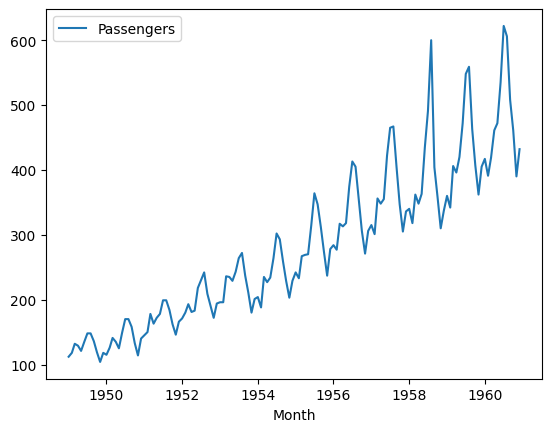

In [9]:
sns.lineplot(data=df)

### Observation and the Anomaly

As with most data like this, it is difficult to visualise any data here. But we can see our anomaly, and we can spot something else going on here with the overall data. It seems like this time-series data is exhibiting some common features of most time-series data which we need to address first. Let's talk about those.

### Time-Series Features and Decomposition

There are two main features that seem apparent from just visualising the data in raw form - trend and seasonality.

Trend - the data is showing movement over time. The trend in data can either be long-term upward or downward movement. Here it is upwards.
Seasonality - repeated patterns in the data at regular intervals. We can see this in the data. It is three peaks before a low dip at each cycle. Since there are four parts to each cycle (3 peaks and 1 dip), we can assume these parts to occur at each season throughout each year, with each cycle lasting a year each.

We can decompose the data into its trend, seaonality and residual components.

In [10]:
def decompose_ts_data(ts_data):
    # Decompose data into trend, seasonality and residual components
    decomp = sm.tsa.seasonal_decompose(ts_data, model='additive')

    # Extract trend, seasonality and residual components
    trend = decomp.trend
    seasonality = decomp.seasonal
    residuals = decomp.resid

    # Plot components
    fig, ax = plt.subplots(4, figsize=(12, 10))

    # Original data
    sns.lineplot(ax=ax[0], data=ts_data)
    ax[0].set_title("Original Data")

    # Trend
    sns.lineplot(ax=ax[1], data=trend)
    ax[1].set_title("Trend")

    # Seasonality
    sns.lineplot(ax=ax[2], data=seasonality)
    ax[2].set_title("Seasonality")

    # Residuals
    sns.lineplot(ax=ax[3], data=residuals)
    ax[3].set_title("Residuals")

    plt.tight_layout()

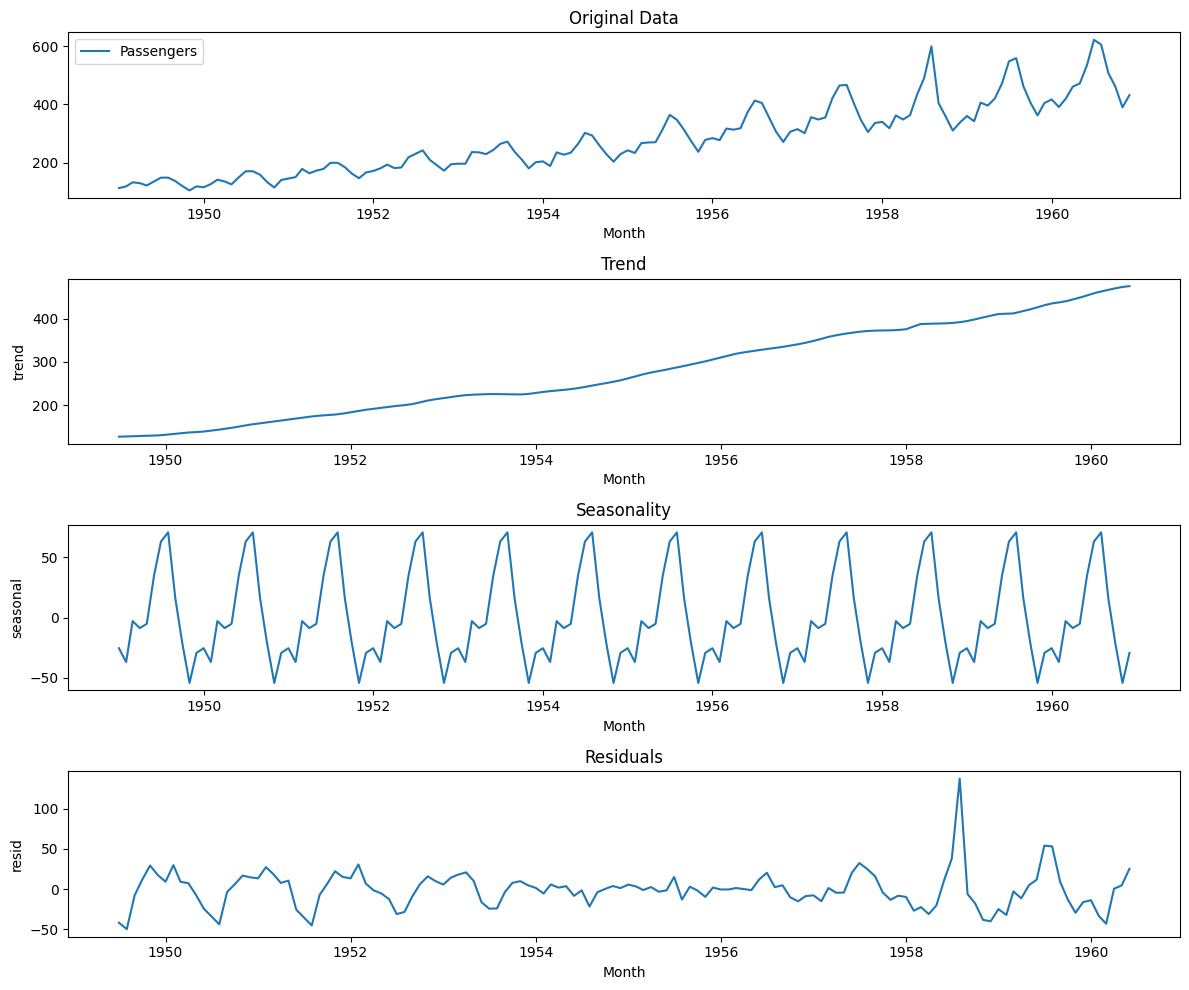

In [11]:
decompose_ts_data(df)

This confirms what we saw from the visual of the raw data. The function has clearly picked up a trend and seasonality patterns that have been plotted. The third graph shows residuals, or in other words 'noise'.

## Data Processing

Ideally, time-series data is not best modelled with when there are things like trend and seasonality, because common statistical models work on the assumption that data is stationary. So we will be performing methods to make our data stationary.

### Stationarity

All time series data and analytics should be done only if the data is stationary. When the data is non-stationary, we need to make it stationary. This because the non-stationarity makes models perform poorly. This is a two-step process:
1. Check for stationarity - although we have seen that trend and seasonality exists in our data, it is common practice to use some tests to check for stationarity.
2. If not stationary, make the data stationary. Otherwise, continue.

#### ADF

There are many statistical tests to check for stationarity in time-series data. The most common is ADF (Augmented Dickey-Fuller Test). We will implement it here.

The ADF test uses the null hypothesis that the time-series data is non-stationary. Therefore, if the null hypothesis is rejected, the data is in fact stationary. However, if we fail to reject the null hypothesis, then indeed the data is non-stationary.

In [12]:
def rol_mean_std(ts_data, window_size):
    # First we need the rolling mean and standard deviation of the data
    rolmean = ts_data.rolling(window=window_size).mean()
    rolstd = ts_data.rolling(window=window_size).std()

    # Plot rolling stats
    fig, ax = plt.subplots(3, figsize=(12,10))

    # Original data
    sns.lineplot(ax=ax[0], data=ts_data)
    ax[0].set_title("Original Data")

    # Rolling mean
    sns.lineplot(ax=ax[1], data=rolmean)
    ax[1].set_title("Rolling Mean")

    # Seasonality
    sns.lineplot(ax=ax[2], data=rolstd)
    ax[2].set_title("Rolling Std")

    plt.tight_layout()

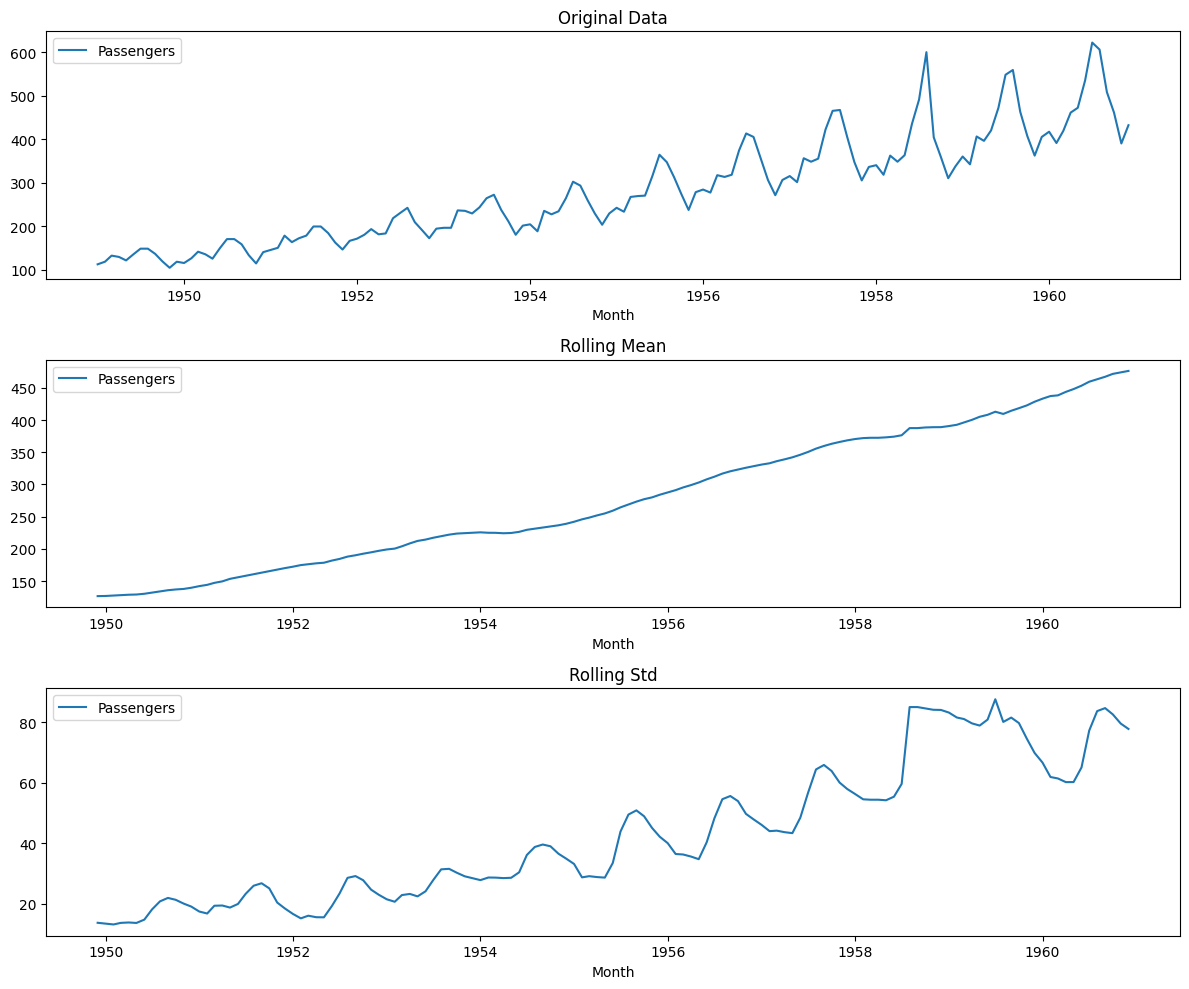

In [13]:
rol_mean_std(df, window_size=12)

This is sort of another verification for the non-stationarity (trend and seasonality).

In [14]:
# Function for ADF test
def adf_test(ts_data):
    # ADF test
    results = st.adfuller(ts_data)

    # Print results
    print("ADF Statistic:", results[0])

    print("p-value:", results[1])

    print("Critical values:")
    for key, value in results[4].items():
        print(key, value)

In [15]:
adf_test(df)

ADF Statistic: 1.7343257174736673
p-value: 0.9982094674937432
Critical values:
1% -3.4816817173418295
5% -2.8840418343195267
10% -2.578770059171598


The first interpretation we can make here is that because p-value (which can be 0 to 1) is far greater than 0.05 (nearly 1), then we cannot reject the null hypothesis that the data is non-stationary, and therefore conclude that the data is non-stationary. The high p-value means the ADF statistic is not statistically significant and it is higher than the critical values at 1%, 5% and 10%. This indicates there is a high chance that the data is not stationary (which we already observed).

Now that we have fully confirmed our observation that the data is non-stationary, as well as identified the trend and seasonality in our data, we can go ahead and perform methods to remove the non-stationary components to make the data stationary.

#### Differencing

There are a few methods in making data stationary, but differencing is the most common. It basically involves finding the difference between two consecutive observations in time. The difference calculated and accumulated one after another can be collected to create a new data series wherein which it will be stationary.

Imagine the difference between two data points is always '5', so it grows by 5 each time. Taking this difference itself for every data point from its previous means we will just have a bunch of 5s. There is no difference in the bunch of 5s since they are all 5s. So the data has become stationary. This is a dumbed-down simple explanation of how differencing works.

In [16]:
# Copy of df
diff_df = df.copy()

# Differencing
diff_df['Differenced'] = df['Passengers'].diff()

# Dropping original data
diff_df = diff_df.drop('Passengers', axis=1)

<AxesSubplot: xlabel='Month'>

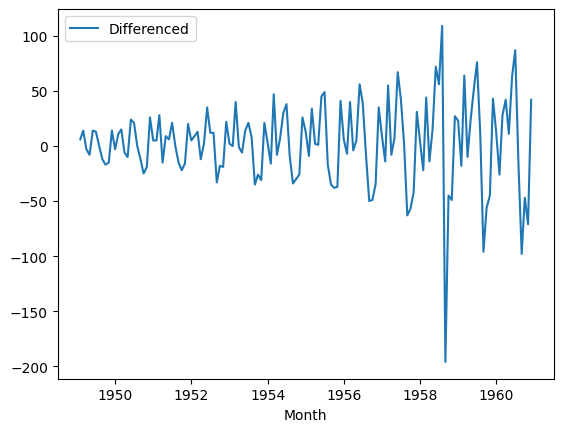

In [17]:
# Check to see if data looks more stationary
sns.lineplot(data=diff_df)

There has become something else that is apparent within the data from this. And if we look back at the initial graphs, we can see it true there also. There is definitely some increasing growth in the differences. It seems that the variance keeps increasing. We can also see that the seasonality remains. Let us deal with both these points by performing log transformation of our data first, and then differencing with a lag of 12 months instead of 1.

##### Log Transformation to remove Increasing Variance and Differencing with Lag 12 to remove Seasonality

In [18]:
def log_data(ts_data, col_name, drop_col=False):
    # Create a copy of the data
    df = ts_data.copy()

    # Find log values
    df['log'] = np.log(df[col_name])

    if drop_col:      
        # Drop original data
        df = df.drop(col_name, axis=1)

    return df

def diff_data(ts_data, col_name, n_lag, drop_col=False):
    # Create copy
    df = ts_data.copy()

    # Difference with lag specified
    df['diff'] = df[col_name].diff(n_lag)

    if drop_col:
        # Drop original column
        df = df.drop(col_name, axis=1)

    # Fill nulls
    df = df.interpolate(method='linear', limit_direction='backward')
    df = df.interpolate(method='linear', limit_direction='forward')

    return df

In [19]:
processed_df = log_data(df, 'Passengers', drop_col=True)
processed_df = diff_data(processed_df, 'log', n_lag=12, drop_col=True)

##### Plot

<AxesSubplot: xlabel='Month'>

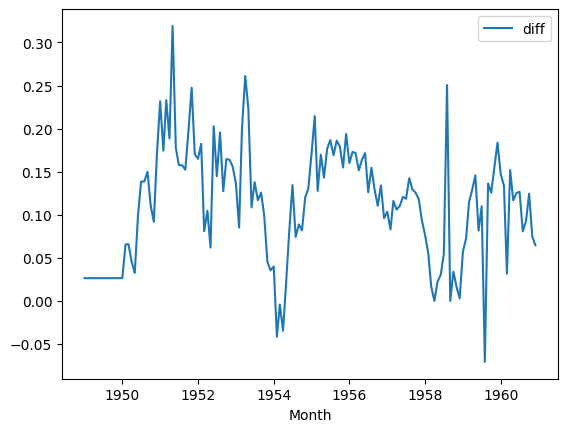

In [20]:
sns.lineplot(data=processed_df)

Now, we can do the ADF test again to check if the data can now be deemed 'stationary':

In [21]:
adf_test(processed_df)

ADF Statistic: -3.46411011084212
p-value: 0.008958105673959047
Critical values:
1% -3.481281802271349
5% -2.883867891664528
10% -2.5786771965503177


Now we can definitely interpret the results as rejecting the null hypothesis that the data is non-stationary. Therefore, we can say the data is definitely stationary. The p-value is much less than 0.05 and the adf statistic is less (more negative) than the critical values at 5% and 10%.

## Modelling

Time-series modelling is usually done using statistical models as opposed to machine-learning models. We will still follow the theme of regression (i.e. forecasting). The most common use of modelling time-series data, as previously mentioned, is predicting values using past values. Here, we can apply that same concept to predict the values for the dataset, and flag any predicted values that deviate from the actual data as anomalies.

### ARMA

The model we will use is the Auto-Regressive Moving Average (ARMA) model. It combines the Auto-Regressive (AR) and Moving Average (MA) models and is used to predict values based on past time-series data (AR part) and past errors (MA part). Both parts require the specification of some order (p for AR and q for MA) of those parts of the model. We can try to determine what p and q should be by plotting the Auto-Correlation Function (ACF - helps determine q) and the Partial Auto-Correlation Function (PACF - helps determine p).

#### ACF and PACF

In [22]:
# Function to plot both acf and pacf
def plot_acf_and_pacf(ts_data, n_lags):
    plot_acf(ts_data, lags=n_lags)
    plot_pacf(ts_data, lags=n_lags)

c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


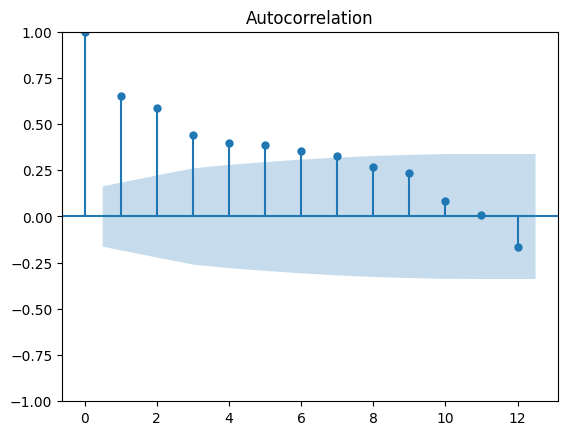

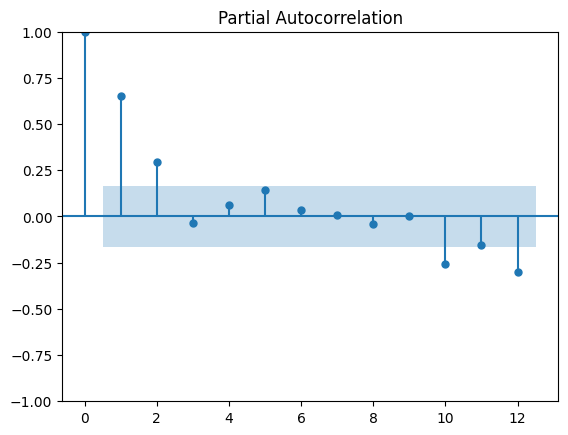

In [23]:
plot_acf_and_pacf(processed_df, n_lags=12)

Both the ACF and the PACF show significant correlation. The blue area can be seen as an area where the correlation can be ignored, so any points above or below it can be seen as correlated points. We can see that ACF indicates a correlation at the first 7 months over a 12-month lag, and PACF indicates strong correlations at months 1, 2, 10 and 12. Therefore we will use a p of 12 and a q of 7.

In [24]:
model = ARIMA(processed_df, order=(12, 0, 7))
model_fit = model.fit()

c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

We've created the model and fitted it to the data. Now what we will do is retrieve the errors (more specifically the mean squared errors) for each data point that the model recorded when fitting each data point and visualise the errors and try and spot our anomaly.

<AxesSubplot: xlabel='Month'>

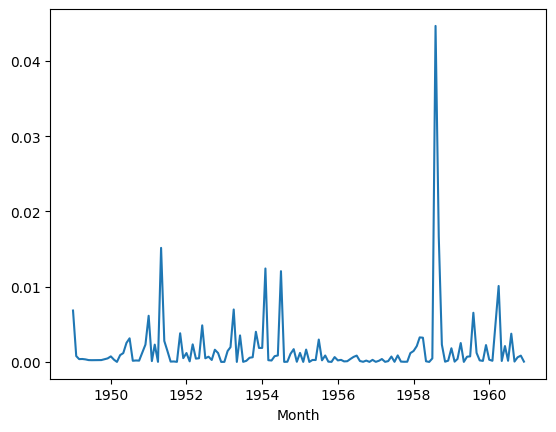

In [25]:
sq_errors = model_fit.resid ** 2
sns.lineplot(sq_errors)

From the graph we can clearly see our anomaly, let's try and retrieve it from where it is.

In [26]:
# Define threshold for outliers (anomalies)
thres = np.mean(sq_errors) + (np.std(sq_errors) * 3)

# Create a dataframe to mark anomalies (squared errors above the threshold)
anoms_df = (sq_errors >= thres).astype(int)

Now we just need to identify which month the anomaly is in!

In [28]:
anoms_df.loc[anoms_df == 1]

Month
1958-08-01    1
dtype: int32

Just as it should be, our anomaly has been detected!

## Anomaly Detection using SARIMA

Another approach without having made the data stationary (without removing the trend and seasonality ourselves) would be to use the Seasonal ARIMA model. The SARIMA model takes care of making the data stationary for us with a parmater d for the I part in SARIMA (Integrated) which assumes the data is non-stationary.

Before plotting the ACF and PACF graphs to help us determine the hyperparameters though, it would still be beneficial to perform log transformation on our data so that we can remove the increasing variance element.

In [29]:
logged_df = log_data(df, 'Passengers', drop_col=True)

There are extra parameters for the Seasonal in SARIMA which are P, D and Q (uppercase p, d and q) which also need to be specified for the seasonality. We need to visualise the seasonal (12-monthly) ACF and PACF for P and Q. Of course, D will be 1 here since that is our seasonal lag as we used last time when differening manually! S is another hyperparameter which we will set as 1 for the yearly cycles.

c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


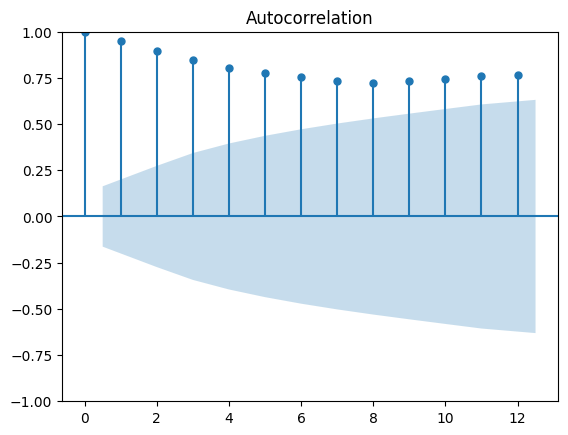

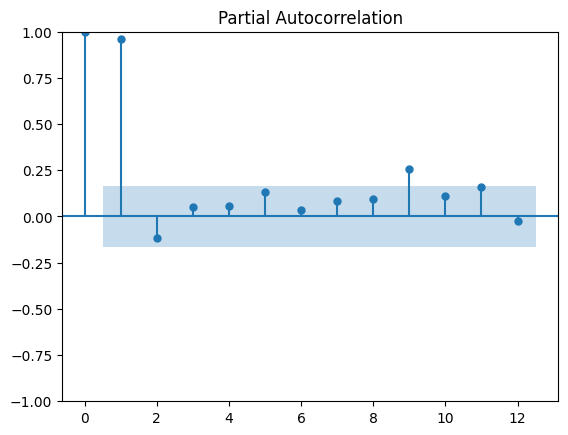

In [30]:
plot_acf_and_pacf(logged_df, n_lags=12)

The ACF has a strong correlation every month over a 12 month lag, and the PACF has strong correlations ar month 1 and 9, so we will use a p and q of 9 and 12.

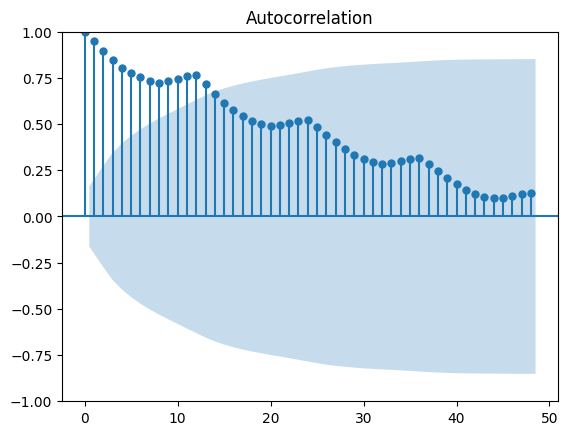

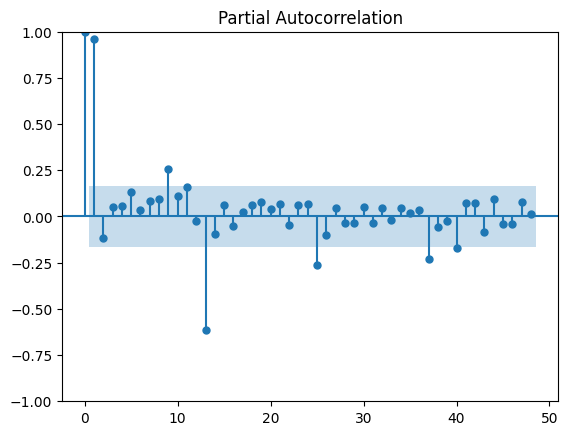

In [31]:
plot_acf_and_pacf(logged_df, n_lags=48)

We can see here that at each 12 month lag period, the ACF keeps dropping off, whereas PACF remains strongly correlated, so we will use a P of 1 and a Q of 0.

p = 9<br>
d = 1<br>
q = 11 (12 is from seasonal)<br>
P = 1<br>
D = 1<br>
Q = 0<br>
S = 12

In [32]:
smodel = ARIMA(df, order=(9, 1, 11), seasonal_order=(1, 1, 0, 12))
smodel_fit = smodel.fit()

c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finally, let's again capture the squared errors of each data point and plot them for the anomaly. As well as identifying the month where it occurs.

<AxesSubplot: xlabel='Month'>

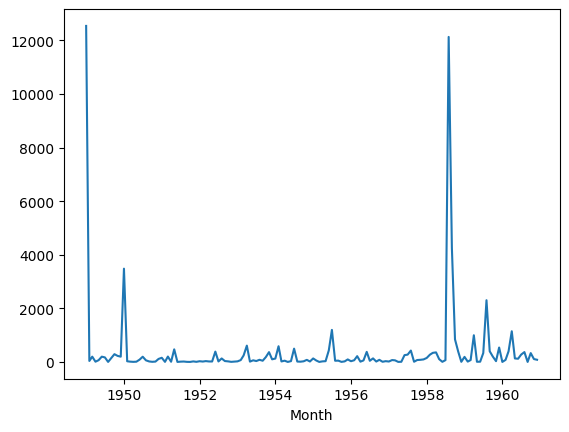

In [33]:
ssq_errors = smodel_fit.resid ** 2
sns.lineplot(ssq_errors)

We can see the anomaly again. We also notice a spike right at the beginning. This is due to the model fitting so it is expected for the model to start off with high errors. Let us identify our anomaly again.

In [34]:
# Define threshold for outliers (anomalies)
sthres = np.mean(ssq_errors) + (np.std(ssq_errors) * 3)

# Create a dataframe to mark anomalies (squared errors above the threshold)
sanoms_df = (ssq_errors >= sthres).astype(int)

# Anomaly month
sanoms_df.loc[sanoms_df == 1]

Month
1949-01-01    1
1958-08-01    1
dtype: int32

We know the error from 1949 is due to the model fitting as mentioned above, so we can ignore that and focus on the actual anomaly which is the one we introduced at the beginning!

## Looking at the Anomaly via Forecasting

Let's see if we can visualse the anomaly using a different technique, we will try and make predictions for the time around the anomaly.

### Creating Train and Test Sets

In [35]:
train_df, test_df = np.split(df, [int(.75*len(df))])

# log the data
train_df = log_data(train_df, 'Passengers', drop_col=True)

Now that we have our train dataset, let's have a quick inspection of it. Of course, we know already what it should look like:

<AxesSubplot: xlabel='Month'>

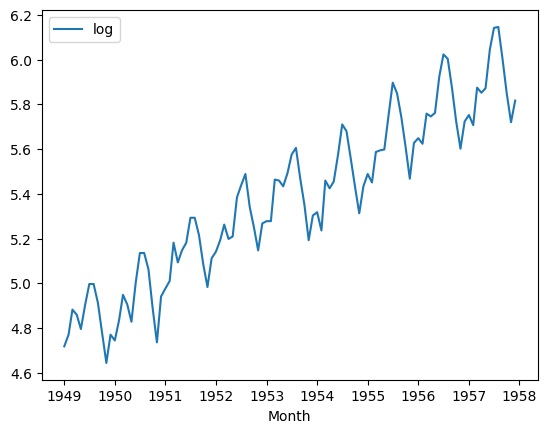

In [36]:
sns.lineplot(train_df)

And we can see our test data containing the anomaly:

<AxesSubplot: xlabel='Month'>

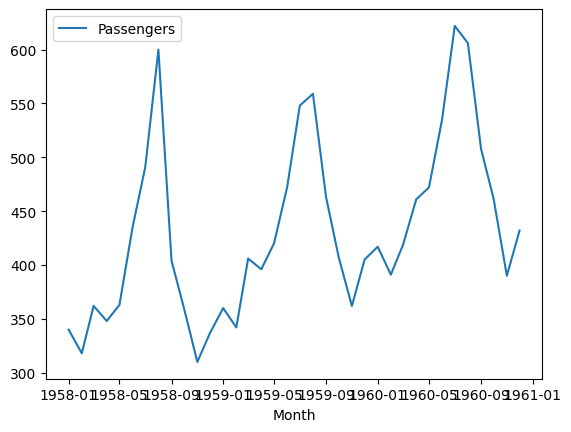

In [37]:
sns.lineplot(test_df)

#### Stationarity

In [38]:
# Quick check for stationarity even though we know it isn't
adf_test(train_df)

ADF Statistic: -0.9974327811794563
p-value: 0.7541994832280592
Critical values:
1% -3.5019123847798657
5% -2.892815255482889
10% -2.583453861475781


We expected this, but as we can see, the p-value is way above 0.05 as it was, and the adf satistic is much higher than all the critical values. Therefore, not enough to reject the null hypothesis that the data is non-stationary, so the data is interpreted from this result as stationary.

#### SARIMA

First we need the ACF and PACF check.

c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


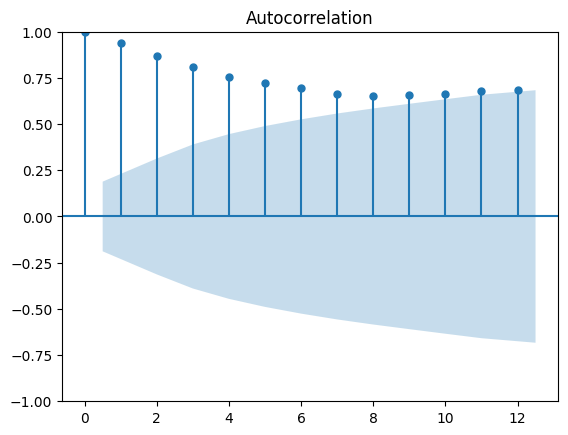

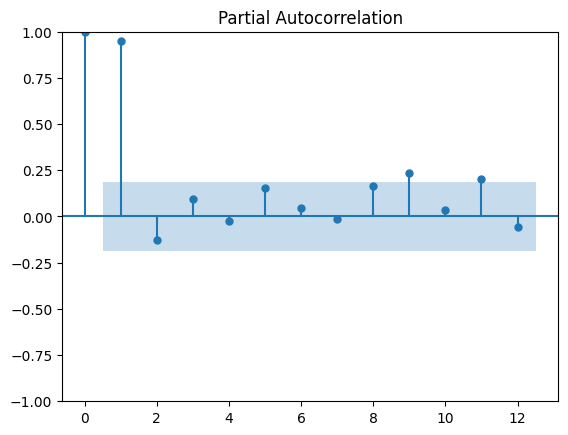

In [39]:
plot_acf_and_pacf(train_df, n_lags=12)

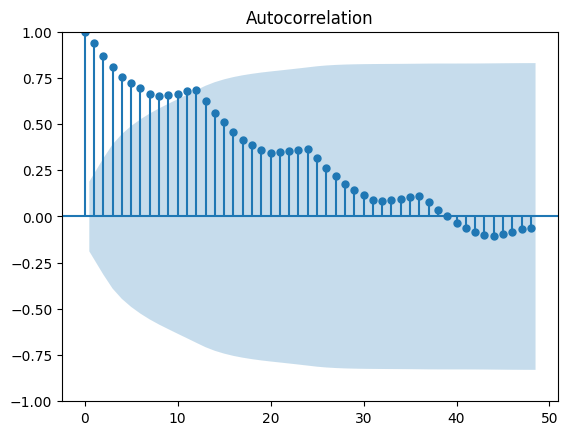

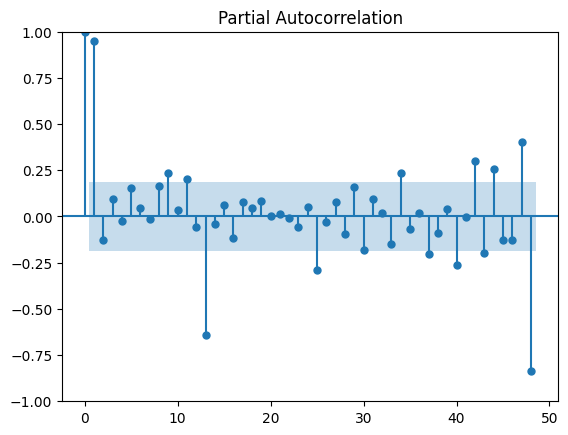

In [40]:
plot_acf_and_pacf(train_df, n_lags=48)

We will use the following values:<br>
p = 11, due to PACF showing correlation at month 11 over a lag of 12 months<br>
d = 1, for trend differencing<br>
q = 11, due to ACF showing correlation at month 12 over a lag of 12 months<br>
P = 1, for PACF showing continuous correlation at 12 month intervals<br>
D = 1, or seasonal differencing<br>
Q = 0, for ACF showing no continuous correlation at 12 month intervals<br>
S = 12, for cycle length.

So we will use the SARIMA model on our non-stationary train data to fit it, and then make forecasts for the next 36 months which will cover the test data period. We will try and visualise the data overlay of the forecast and the test set, so we can see the anomaly clearly.

In [41]:
# Forecast
model = ARIMA(train_df, order=(11, 1, 11), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit()
log_forecast = model_fit.forecast(36)
forecast = np.exp(log_forecast)

c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abu Hasan\Miniconda\envs\anomaly-ts-forecasting\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Abu Hasan\M

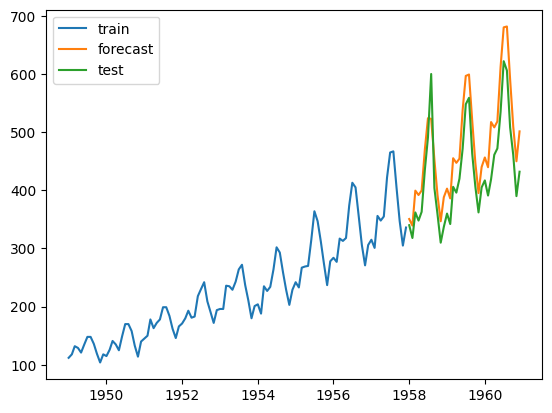

In [42]:
# Plot
plt.plot(np.exp(train_df), label='train')
plt.plot(forecast, label='forecast')
plt.plot(test_df, label='test')
plt.legend()
plt.show()

As we can see, the forecast was off during the year of 1958, especially for around where we introduced the anomaly. Due to the anomaly as well we have seen that the future forecasts are also affected (higher spikes for the forecasts of 1959 and 1960).

## Conclusion

Although there are many, arguably more precise, ways of performing anomaly detection, the purpose of this notebook was to illustrate the method of using forecasting and auto-regressive models to indicate anomalies in simple cases.